In [232]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import math

In [233]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [234]:
batch_size = 128
epochs = 100
log_interval = 10
x_dim = 100
y_dim = 100
nb_channels = 3
embedding_dim = 2048
base_dir = '../data/fruits-360'

## Load data

In [235]:
def load_dataset(data_path):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([torchvision.transforms.RandomAffine(45, fillcolor=(255, 255,255), scale=(0.5,0.9)),
                                      torchvision.transforms.ToTensor()])
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader

train_loader = load_dataset(f'{base_dir}/Training')
test_loader = load_dataset(f'{base_dir}/Test')

## Example image

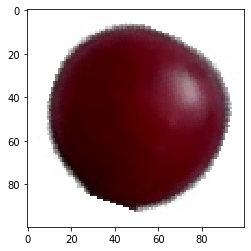

In [236]:
img = next(iter(train_loader))[0][0]
img = img.permute(1, 2, 0)
img = img.view(img.shape[0], img.shape[1], nb_channels)
img.shape
plt.figure()
plt.imshow(img.numpy())
plt.show()

## Models

In [237]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim*y_dim*nb_channels, 400)
        self.fc21 = nn.Linear(400, embedding_dim)
        self.fc22 = nn.Linear(400, embedding_dim)
        self.fc3 = nn.Linear(embedding_dim, 400)
        self.fc4 = nn.Linear(400, x_dim*y_dim*nb_channels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim*y_dim*nb_channels))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [264]:

class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv31 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(128)
        self.conv32 = nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, embedding_dim)
        self.fc_bn1 = nn.BatchNorm1d(embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)

        # Sampling vector
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc_bn3 = nn.BatchNorm1d(embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv31 = self.relu(self.bn31(self.conv31(conv3)))
        conv32 = self.relu(self.bn32(self.conv32(conv31)))
        conv4 = self.relu(self.bn4(self.conv4(conv32))).view(-1, 25 * 25 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [265]:
model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Loss

In [266]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim*y_dim*nb_channels), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [267]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [268]:
# Set loss function used by train and test here
loss_func = CustomLoss()

## Train

In [269]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_func(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

## Test

In [270]:
import os
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, nb_channels, x_dim, y_dim)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Main

In [271]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(batch_size, embedding_dim).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(batch_size, nb_channels, x_dim, y_dim),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/55413 (0%)]	Loss: 33472.312500


KeyboardInterrupt: 